In [1]:
import sympy as sy
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn import*
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
random_state=1 # зададим тут стразу random_state

### Загрузим данные

In [2]:
df = pd.read_csv('data.csv')
df

Activity        D1        D2    D3   D4        D5        D6        D7  \
0            1  0.000000  0.497009  0.10  0.0  0.132956  0.678031  0.273166   
1            1  0.366667  0.606291  0.05  0.0  0.111209  0.803455  0.106105   
2            1  0.033300  0.480124  0.00  0.0  0.209791  0.610350  0.356453   
3            1  0.000000  0.538825  0.00  0.5  0.196344  0.724230  0.235606   
4            0  0.100000  0.517794  0.00  0.0  0.494734  0.781422  0.154361   
...        ...       ...       ...   ...  ...       ...       ...       ...   
3746         1  0.033300  0.506409  0.10  0.0  0.209887  0.633426  0.297659   
3747         1  0.133333  0.651023  0.15  0.0  0.151154  0.766505  0.170876   
3748         0  0.200000  0.520564  0.00  0.0  0.179949  0.768785  0.177341   
3749         1  0.100000  0.765646  0.00  0.0  0.536954  0.634936  0.342713   
3750         0  0.133333  0.533952  0.00  0.0  0.347966  0.757971  0.230667   

            D8        D9  ...  D1767  D1768  D1769  D1770  D1771  D1772  \
0     0.585445  0.743663  ...      0      0      0      0      0      0   
1     0.411754  0.836582  ...      1      1      1      1      0      1   
2     0.517720  0.679051  ...      0      0      0      0      0      0   
3     0.288764  0.805110  ...      0      0      0      0      0      0   
4     0.303809  0.812646  ...      0      0      0      0      0      0   
...        ...       ...  ...    ...    ...    ...    ...    ...    ...   
3746  0.376124  0.727093  ...      0      0      0      0      0      0   
3747  0.404546  0.787935  ...      0      0      1      0      1      0   
3748  0.471179  0.872241  ...      0      0      0      0      0      0   
3749  0.447162  0.672689  ...      0      0      0      0      0      0   
3750  0.272652  0.854116  ...      0      0      0      0      0      0   

      D1773  D1774  D1775  D1776  
0         0      0      0      0  
1         0      0      1      0  
2         0      0      0      0  
3         0      0      0      0  
4         0      0      0      0  
...     ...    ...    ...    ...  
3746      0      0      0      0  
3747      1      0      0      0  
3748      0      0      0      0  
3749      0      0      0      0  
3750      0      0      0      0  

[3751 rows x 1777 columns]

#### Проверим на пропуски

In [3]:
df.isna().sum().sum()

0

### Так как все нормализоване и закодировано - разметим

In [4]:
y=df.iloc[:,0]
X=df.iloc[:,1:]


### проверим сбалансированность классов

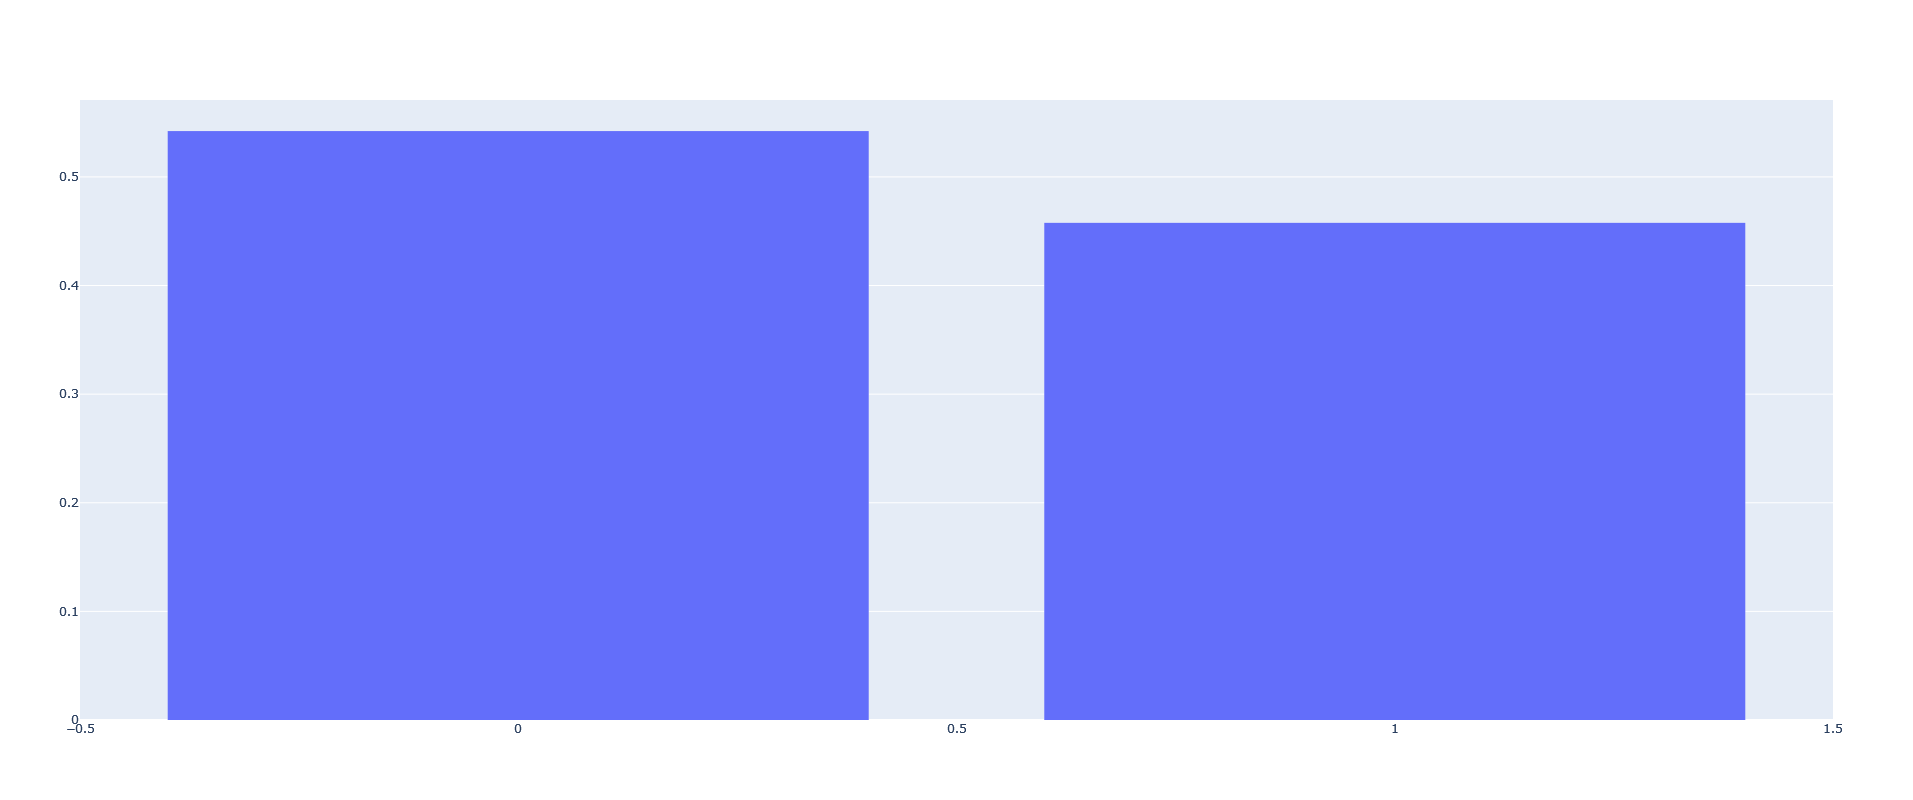

In [5]:
fig=make_subplots(rows=1,cols=1)
objects=[go.Bar(y=y.value_counts(normalize=True),name='y',marker_line_color='white',marker_line_width=0.1)]
fig.add_traces(objects,rows=[1],cols=[1])
fig.update_layout(height=800,width=1000)
fig.show()

### 54 и 46%-неплохо сбалансированы

# переходим к водным процедурам

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (X, y, stratify=y, test_size=0.2, random_state=random_state)


## базовая логистическая регрессия

In [7]:
%%time
log_reg=linear_model.LogisticRegression(random_state=random_state, n_jobs=-1).fit(X_train,y_train)
y_train_pred = log_reg.predict (X_train)
y_test_pred = log_reg.predict (X_test)
#       выведем метрики для тренировочного и тестового наборов
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))   
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.89
f1_score на тестовом наборе: 0.78
CPU times: total: 172 ms
Wall time: 6.99 s


### очень долго решает.от 4.92 до 7.9 секунд на базовых настройках на 12 ядерном процессоре с 24 потоками используя все потоки... Я не представляю что будет при оптимизации

### создадим сетку для лог.регрессии

In [8]:
log_reg_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'saga', ],           # алгоритм оптимизации 
              'C': np.arange(0.1 , 1.01 , 0.1),              # коэф. регуляризации
              'max_iter': np.arange(100, 1001, 100)}             # кол. итераций  

### так как не все гипепараметры комбинируется между сосбой, в дальнейшем просто будем игонорировать warnings

In [9]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## базовый лес

In [10]:
%%time
tree = ensemble.RandomForestClassifier(random_state=random_state, n_jobs=-1).fit(X_train, y_train)
y_train_pred = tree.predict (X_train)
y_test_pred = tree.predict (X_test)
#       выведем метрики для тренировочного и тестового наборов
print('f1_score на ренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))   
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на ренировочном наборе: 1.00
f1_score на тестовом наборе: 0.82
CPU times: total: 1.41 s
Wall time: 283 ms


### Тут со скоростью все нормально

### создадим сетку для random forest

In [11]:
rf_grid = {'min_samples_leaf': np.arange(3, 10, 1),                  # количество объектов в листе
              'max_depth': np.arange(5, 10 ,1),                       # максимальная глубина
              'criterion':['entropy','gini']                          # критерий информативности
              }

# I. Приступим к оптимизации гиперпараметров лог. регрессии

## 1. Используем GridSearchСV для регрессии

In [12]:
%%time
grid_search_log_reg = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state,n_jobs=-1), # модель для оптимизации
    param_grid=log_reg_grid,                                                            # сетка праметров
    cv=5,                                                                               # кросс валидация
    n_jobs = -1
)  
grid_search_log_reg.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_log_reg.score(X_test, y_test)))
y_test_pred = grid_search_log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_log_reg.best_params_))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.2, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: total: 29.4 s
Wall time: 50min 14s


### Да уж... Полную сетку прошло за 50 минут с результатом 0.78 на процессоре ryzen 5900x в многопоточном режиме. Нерационално по времени.

## 2. Используем RandomizedSearchСV для регрессии

In [13]:
%%time
random_search = model_selection. RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000), 
    param_distributions = log_reg_grid, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
).fit(X_train, y_train)  
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 0.2}
CPU times: total: 2.05 s
Wall time: 2min 20s


### Вот это более менее. 2:20 с тем же рузльтатом метрики

## 3. Используем Hyperopt для регрессии

In [14]:
# зададим пространство поиска гиперпараметров . Тут warnings пропустить не получиться и поэтому надо явно создать рабочие комбинации в space
# как вариант
grid={'penalty': ['l1', 'l2'],
       'solver' :  ['liblinear', 'saga', ],
       'C': np.arange(0.1, 1.01, 0.1)}
space={'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver' : hp.choice('solver', ['liblinear', 'saga', ]),
       'C': hp.quniform('C', 0.1, 1.01, 0.1)}
       
# функция для использования в Hyperopt
def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
              'C': float(params['C'])
               }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state,n_jobs=-1).fit(X,y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [16]:
%%time
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_log_reg, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:41<00:00,  2.06s/trial, best loss: -0.8823709135349832]
Наилучшие значения гиперпараметров {'C': 0.9, 'penalty': 1, 'solver': 0}
CPU times: total: 41.2 s
Wall time: 41.2 s


### - сама модель с параметрами по результатам

In [17]:
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=str(grid['penalty'][best['penalty']]),
    solver=str(grid['solver'][best['solver']]),
    C=float(best['C']),
    n_jobs=-1
).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78


## 4. Используем OPTUNA для регрессии

In [18]:
# функция как и для Hyperopt
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', ])
    C = trial.suggest_float('C', 0.1 , 1  )

    # создаем модель
    model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state).fit(X_train,y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    return score

In [19]:
%%time
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

[I 2022-05-31 16:51:38,935] A new study created in memory with name: LogisticRegression
[I 2022-05-31 16:51:42,410] Trial 0 finished with value: 0.8685015290519879 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.7269894258263867}. Best is trial 0 with value: 0.8685015290519879.
[I 2022-05-31 16:51:47,016] Trial 1 finished with value: 0.8504559270516718 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7404575337922943}. Best is trial 0 with value: 0.8685015290519879.
[I 2022-05-31 16:51:47,249] Trial 2 finished with value: 0.8825688073394496 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9251629520602666}. Best is trial 2 with value: 0.8825688073394496.
[I 2022-05-31 16:51:47,478] Trial 3 finished with value: 0.8707899571341091 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.4305250996615043}. Best is trial 2 with value: 0.8825688073394496.
[I 2022-05-31 16:51:51,963] Trial 4 finished with value: 0.8450789793438638 and parameters: {'

CPU times: total: 46.1 s
Wall time: 46.1 s


In [20]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9995478320431598}
f1_score на обучающем наборе: 0.89


### -сама модель по результатам

In [21]:
# рассчитаем метрику для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, ).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


### Получили то же, что и в Hyperopt примерно за то же время
### Немного визуализации оптимизаций

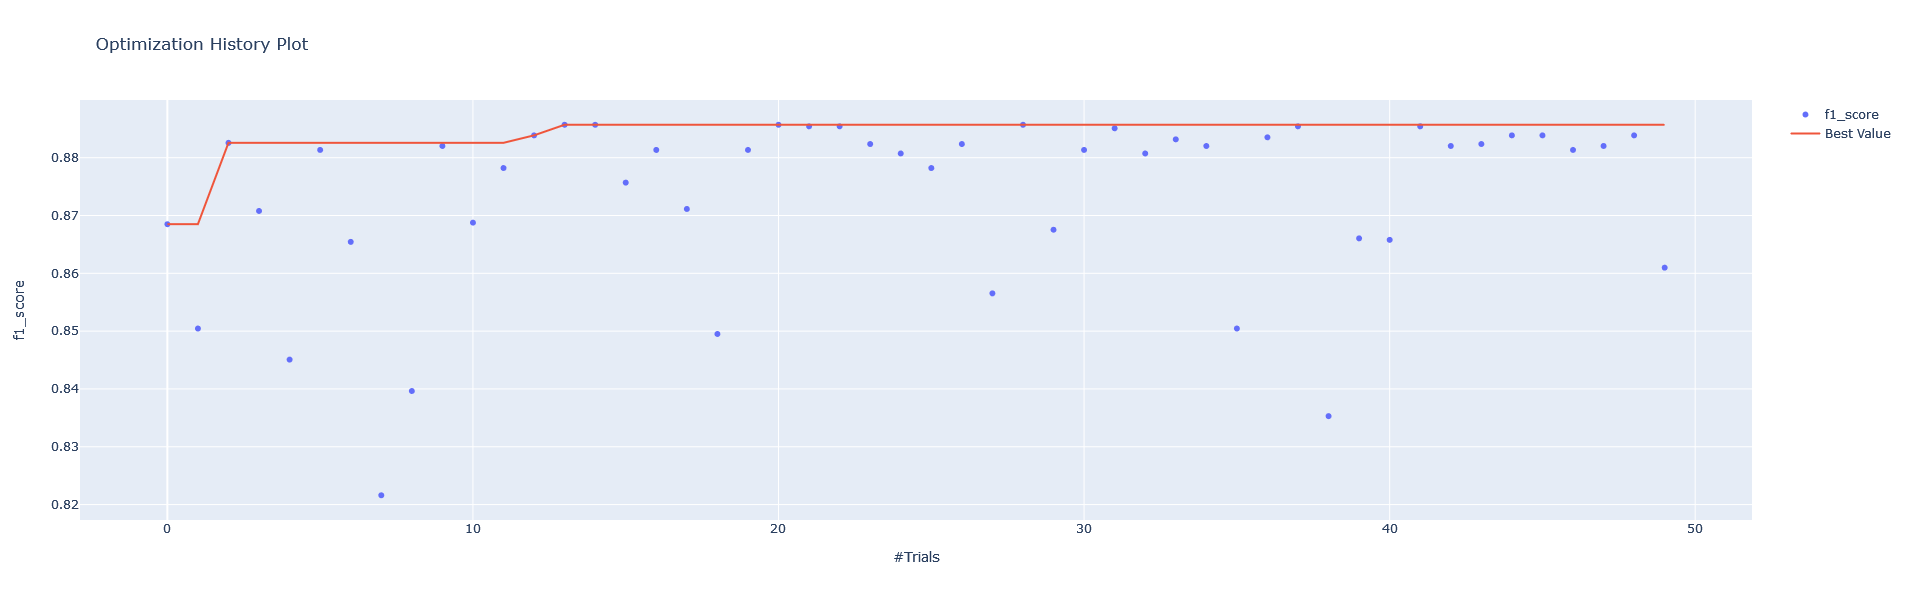

In [22]:
fig=optuna.visualization.plot_optimization_history(study, target_name="f1_score")
fig.update_layout(height=600,width=1000)
fig.show()

### на 15 итерации метрика более менее стабилизировалась

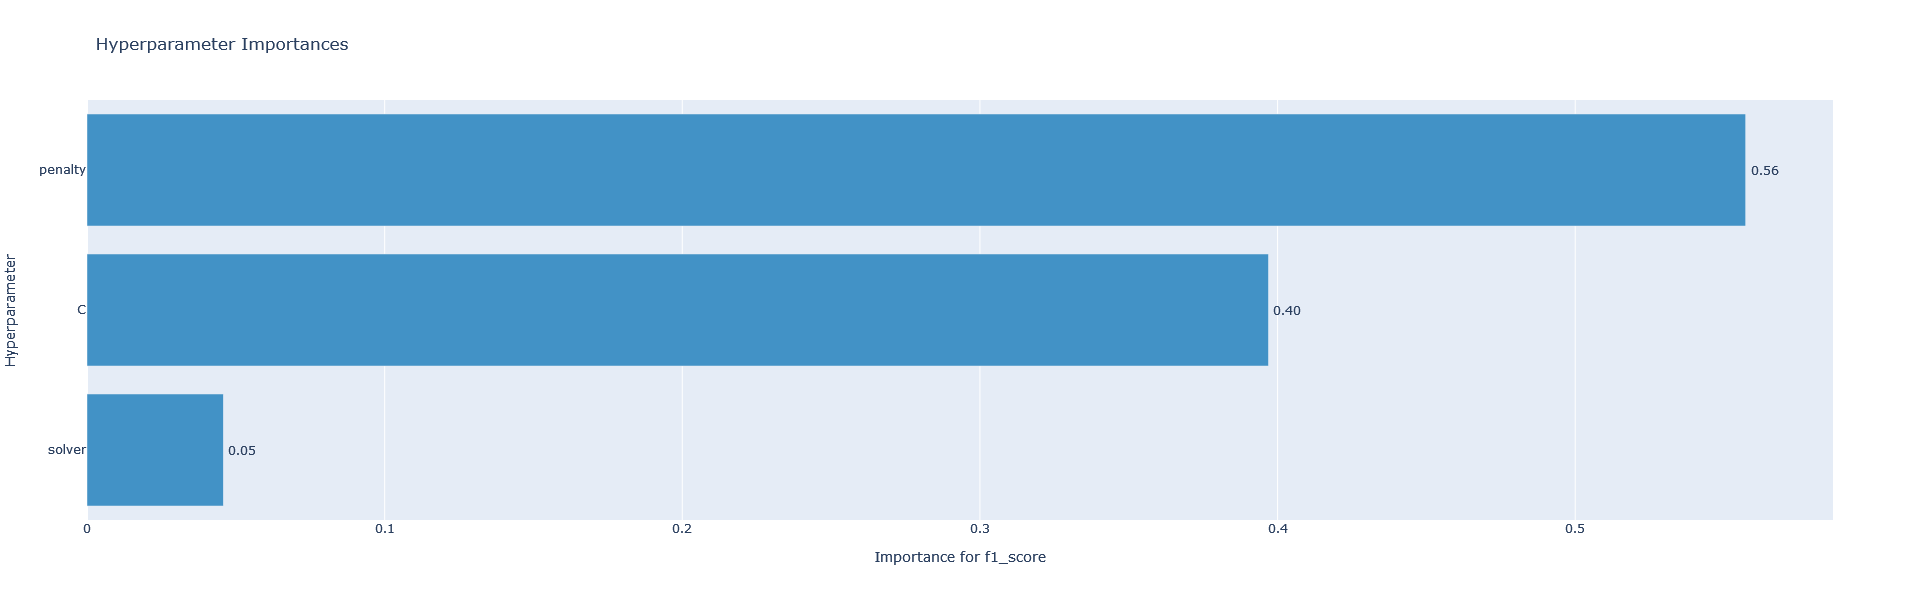

In [23]:
fig=optuna.visualization.plot_param_importances(study, target_name="f1_score")
fig.update_layout(height=600,width=1000)
fig.show()

### метод регуляризации решает

# II. Приступим к оптимизации гиперпараметров случайного леса

## 1. Используем GridSearchСV для случайного леса

In [24]:
%%time
grid_search_forest = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=rf_grid, 
    cv=5, 
    n_jobs = -1
).fit(X_train, y_train) 
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3}
CPU times: total: 2.69 s
Wall time: 25.6 s


## 2. Используем RandomizedSearchСV для случайного леса

In [25]:
%%time
random_search_forest = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=rf_grid, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
).fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'min_samples_leaf': 3, 'max_depth': 9, 'criterion': 'entropy'}
CPU times: total: 2.22 s
Wall time: 16.1 s


## 3. Используем Hyperopt для RandomForest

In [26]:
# зададим пространство поиска гиперпараметров 
space={'n_estimators': hp.quniform('n_estimators', 100, 301, 10),
       'max_depth' : hp.quniform('max_depth', 5, 10, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 10, 1)
      }
# функция для использования в Hyperopt
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state,n_jobs=-1).fit(X,y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


### - теперь начнем непосредственный перебор

In [27]:
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:07<00:00,  2.79trial/s, best loss: -0.9134585771481368]
Наилучшие значения гиперпараметров {'max_depth': 10.0, 'min_samples_leaf': 4.0, 'n_estimators': 220.0}


### - сама модель по результатам

In [28]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    n_jobs=-1
).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.91
f1_score на тестовом наборе: 0.80


## 4. Используем OPTUNA для случайного леса

In [29]:
# функция как и для Hyperopt
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 301, 10)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state).fit(X_train,y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    return score

In [30]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

[I 2022-05-31 16:55:59,707] A new study created in memory with name: RandomForestClassifier
[I 2022-05-31 16:56:00,445] Trial 0 finished with value: 0.8009873495834618 and parameters: {'n_estimators': 170, 'max_depth': 5, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8009873495834618.
[I 2022-05-31 16:56:01,380] Trial 1 finished with value: 0.9062403934829388 and parameters: {'n_estimators': 130, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9062403934829388.
[I 2022-05-31 16:56:02,465] Trial 2 finished with value: 0.9170251997541488 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9170251997541488.
[I 2022-05-31 16:56:03,406] Trial 3 finished with value: 0.8267983945662241 and parameters: {'n_estimators': 210, 'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9170251997541488.
[I 2022-05-31 16:56:04,554] Trial 4 finished with value: 0.8677736777367774 and parameters: {'n_e

CPU times: total: 1min 12s
Wall time: 1min 12s


In [31]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.92


### - сама модель по результатам

In [32]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, ).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.92
f1_score на тестовом наборе: 0.80


## -немного визуализаций оптимизации

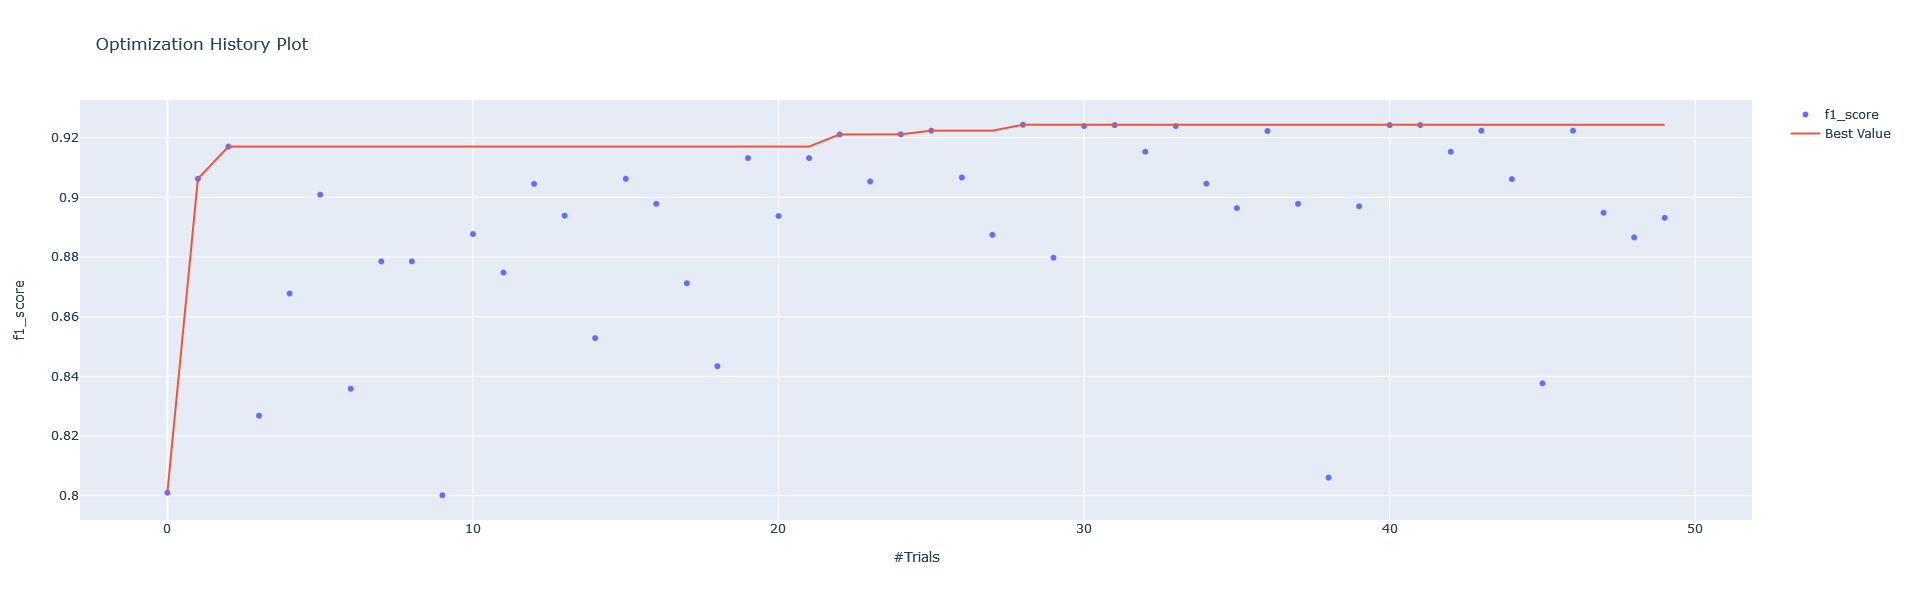

In [33]:
fig=optuna.visualization.plot_optimization_history(study, target_name="f1_score")
fig.update_layout(height=600,width=1000)
fig.show()

### как видим после 20 интераций метрика более -менее стабилизировалась

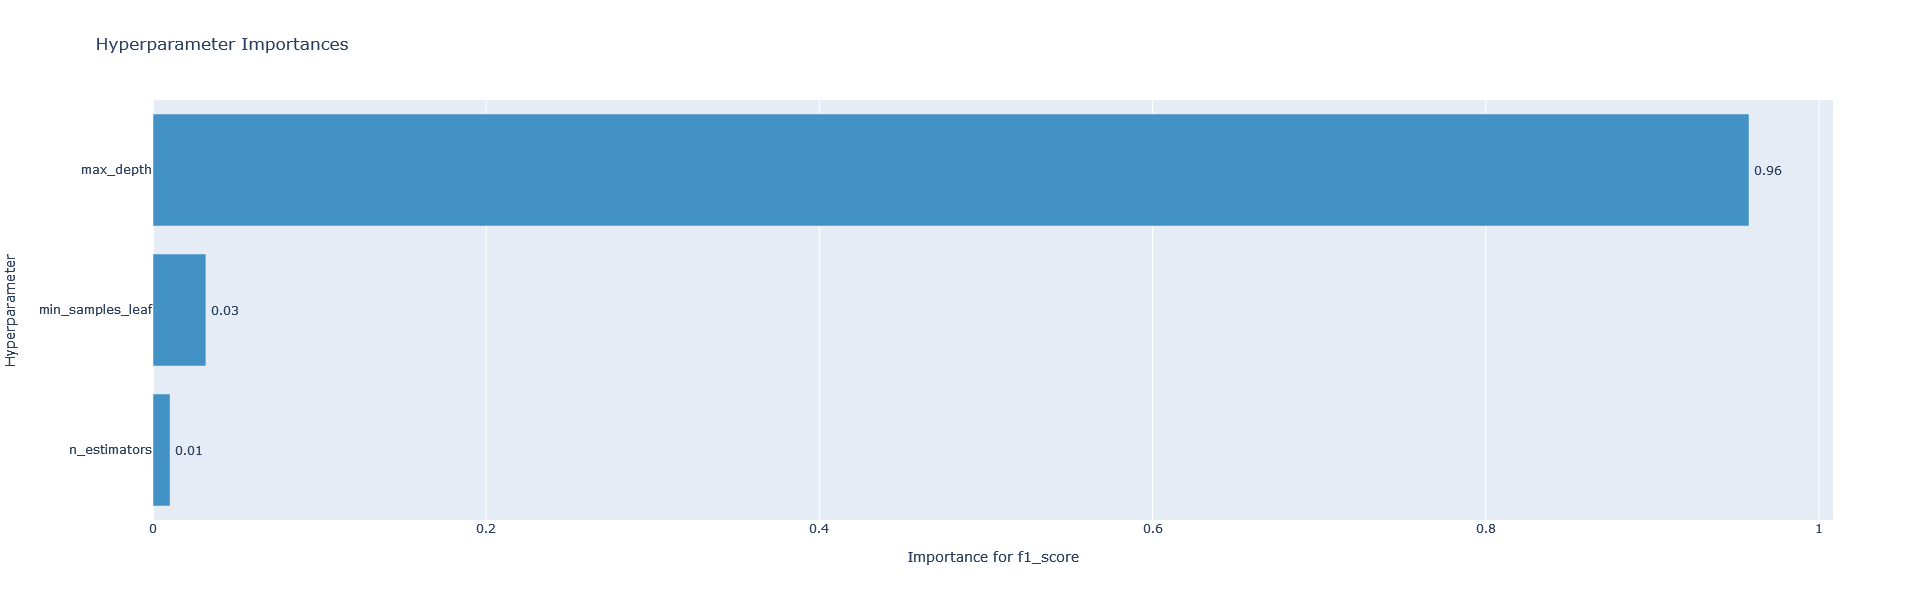

In [34]:
fig=optuna.visualization.plot_param_importances(study, target_name="f1_score")
fig.update_layout(height=600,width=1000)
fig.show()

### Как видим важность гиперпараметров. Глубина дерева решает

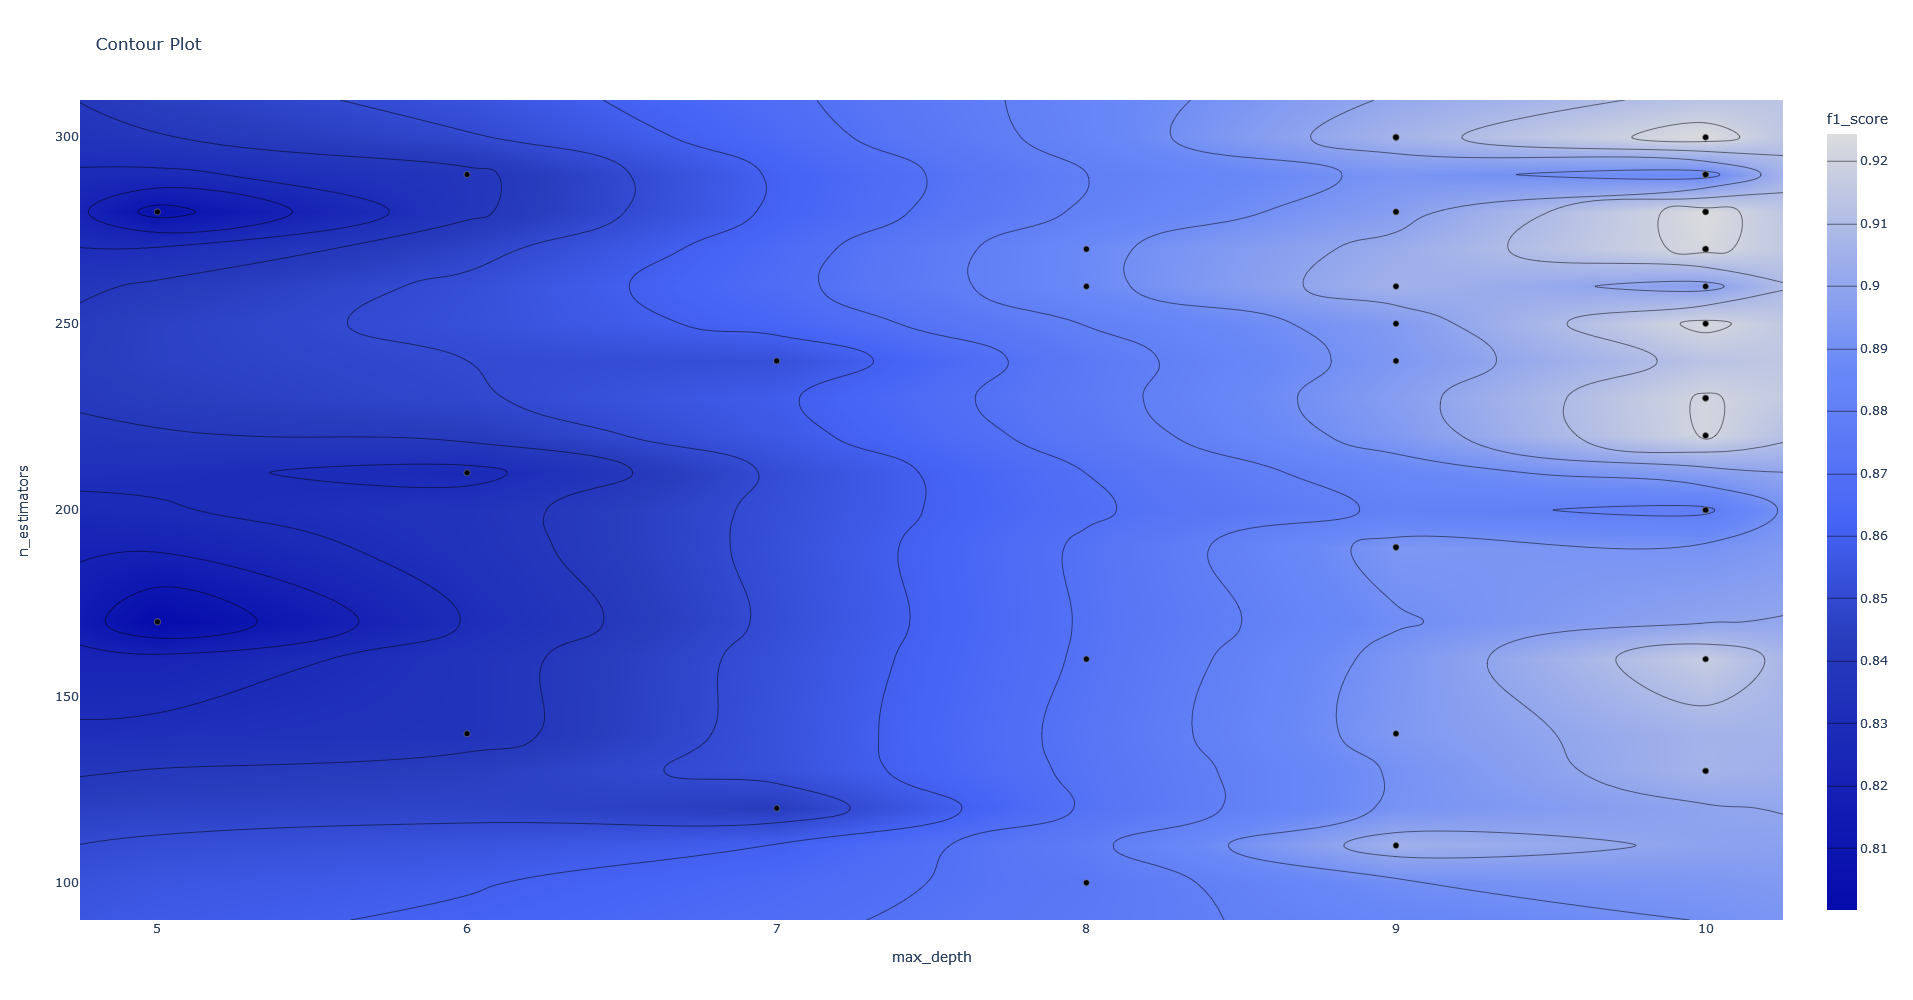

In [35]:
fig=optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")
fig.update_layout(height=1000,width=1000)
fig.show()

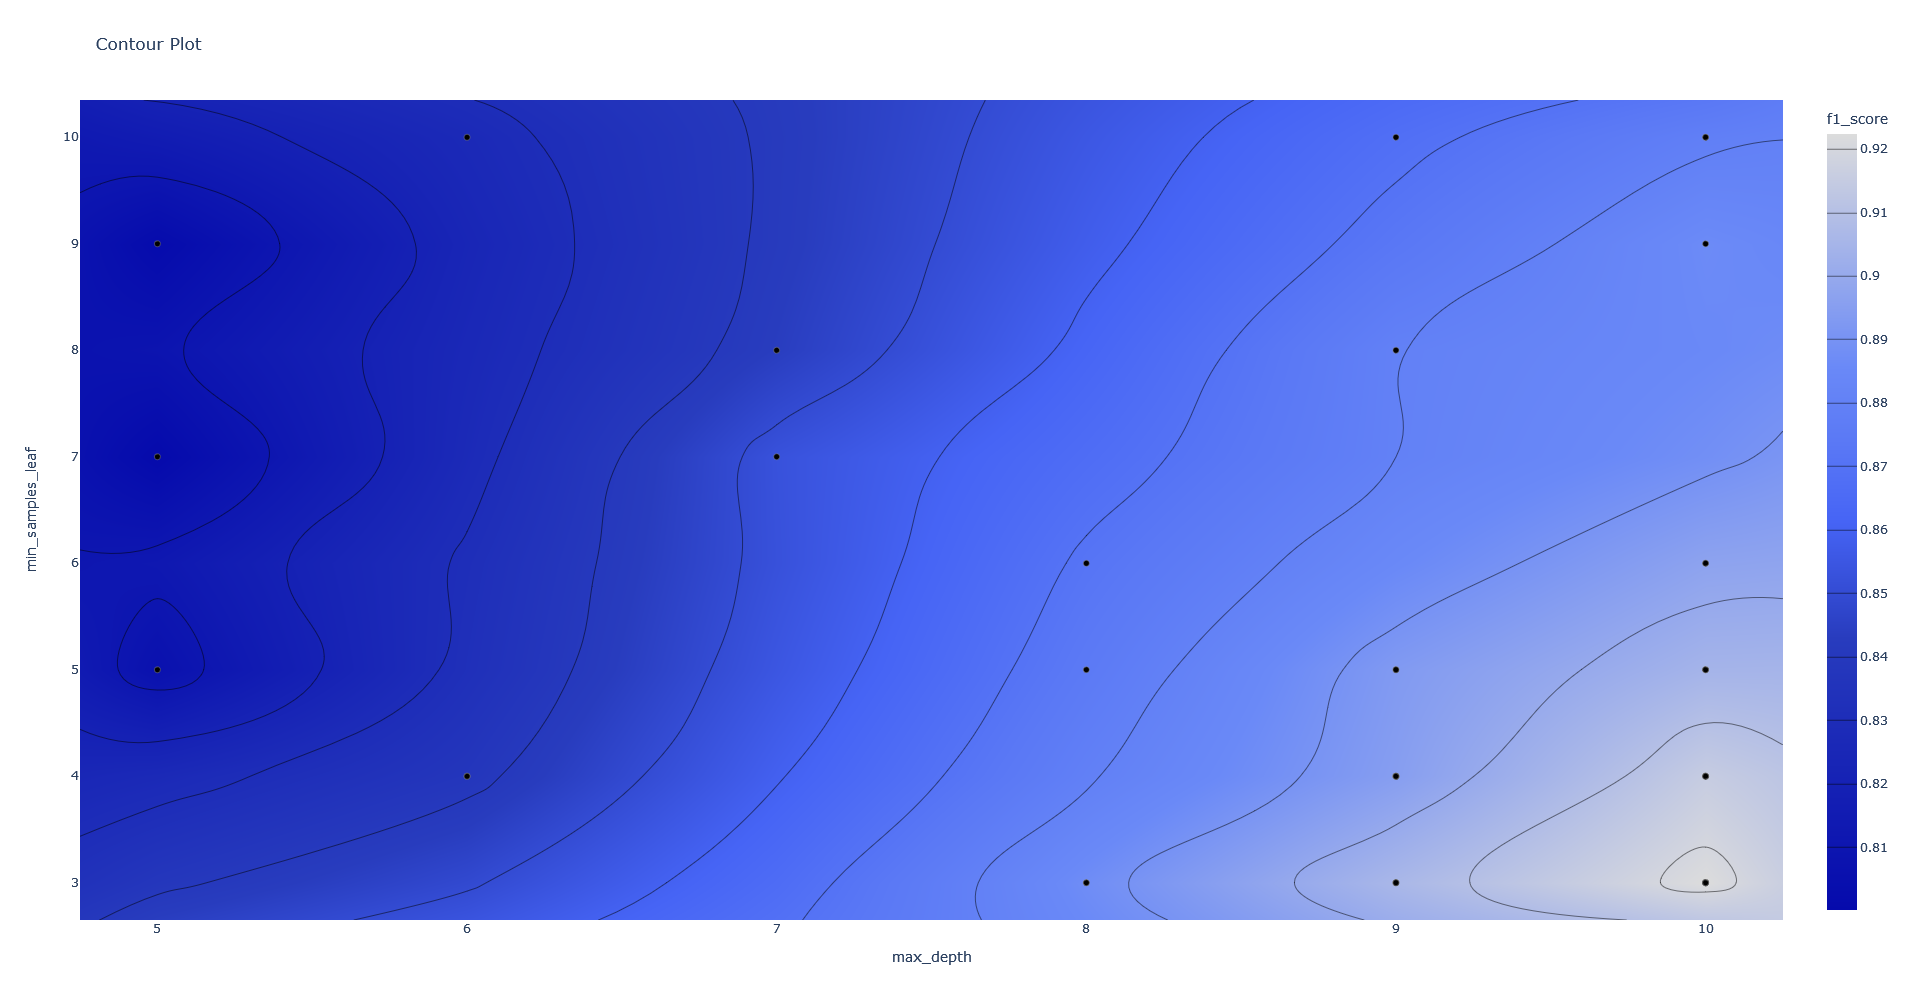

In [38]:
fig=optuna.visualization.plot_contour(study, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")
fig.update_layout(height=1000,width=1000)
fig.show()

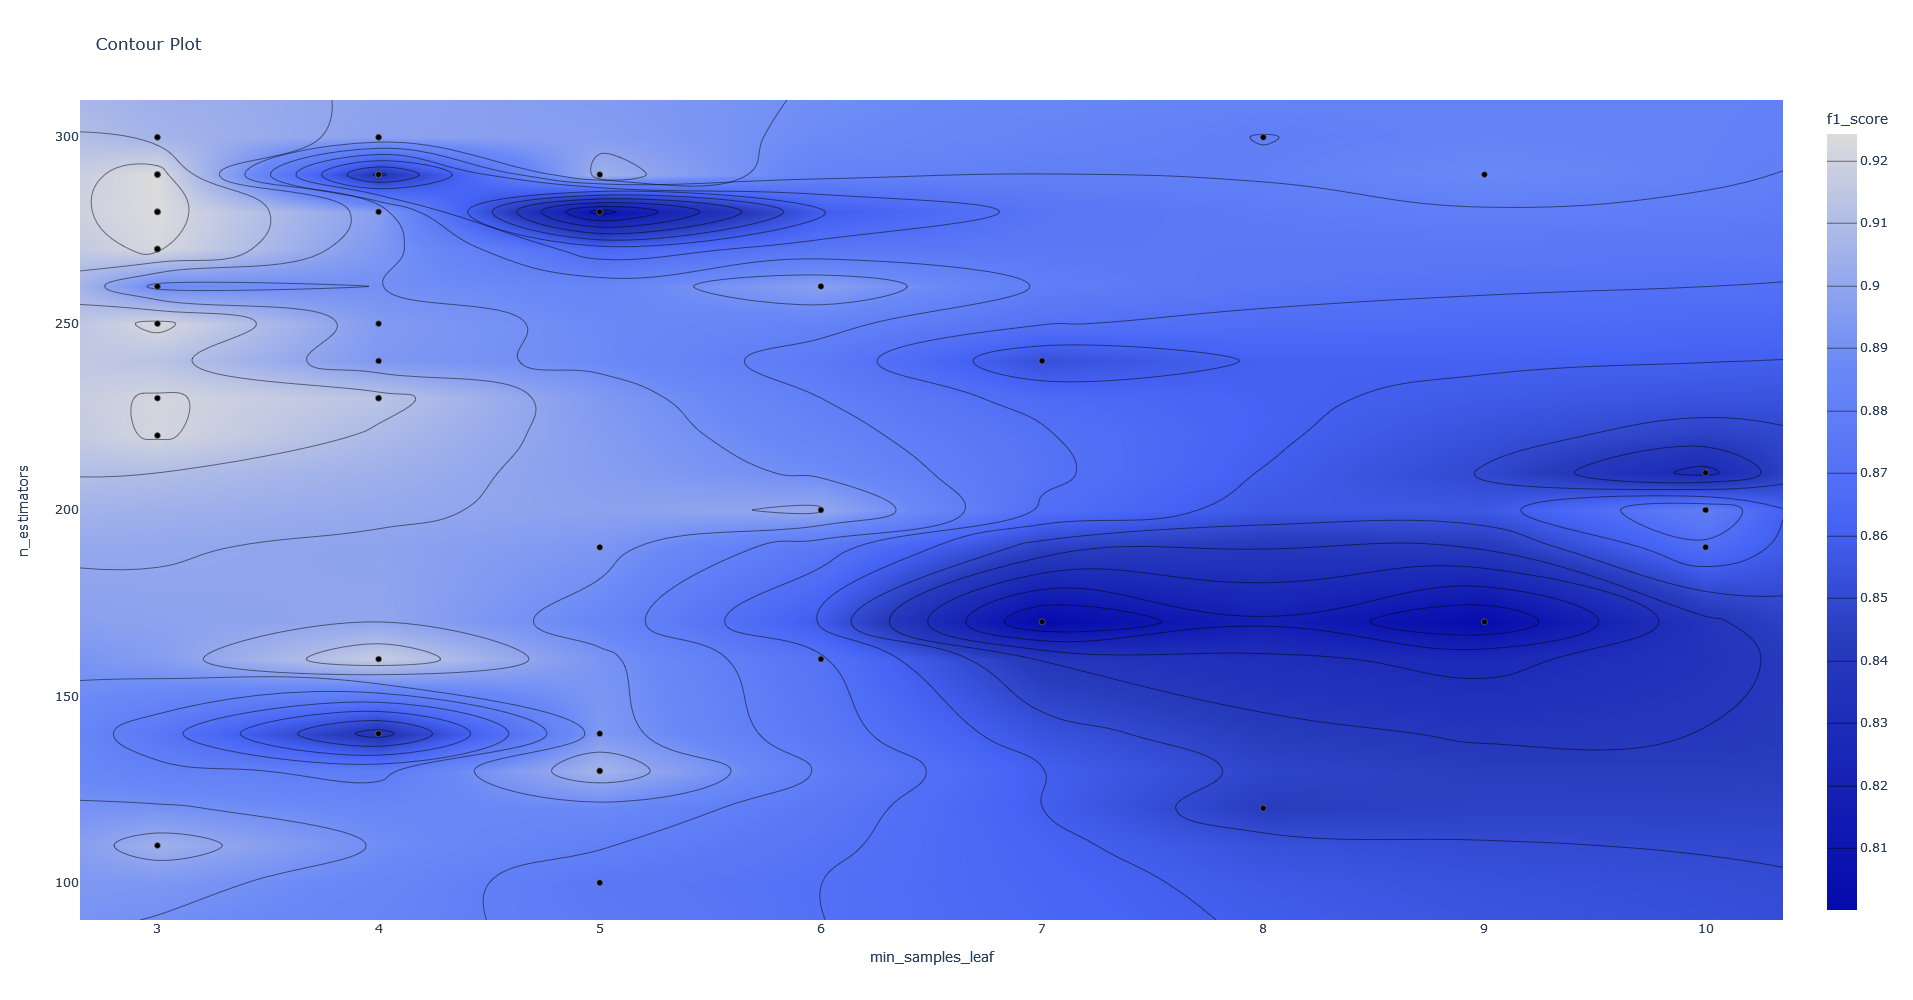

In [39]:
fig=optuna.visualization.plot_contour(study, params=["min_samples_leaf","n_estimators"],
                                  target_name="f1_score")
fig.update_layout(height=1000,width=1000)
fig.show()

### Тут наглядно влияние 2 праметров

# Выводы
## -Из двух моделей случайных лес отработал лучше. 
## -Использовано 4 инструмента оптимизации гиперпараметров и получены сравнимые результаты по метрике.В среднем оптимизация парметров леса привела к стабилизации метрики на 0.8 (0.78 для регрессии)
## -Однако эти иструменты решают задачу за различное время. Специализированные библиотки имеют обширный функционал и справляются  быстрее
## -Я лично смотрю в стороны OPTUNA 